# Vis model  2

Using device: cuda
Filtered Data Count (Difficulty>=15): 81
Selected Song ID: ztz.bbb
Audio Path: /data1/yuchen/cytoid/dataset/Z/ztz.bbb.cytoidlevel/HiTECH NINJA,Cranky - BREaK! BREaK! BREaK!.ogg
Total Time: 151.88 seconds
Loaded Presence Model
Loaded Type Model

=== Entire Song Metrics ===

Presence Confusion Matrix (Entire Song):
 [[5432   46]
 [ 532  531]]


/tmp/ipykernel_3211455/1362782787.py:426: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  presence_model.load_state_dict(torch.load(PRESENCE_MODEL_PATH, map_location=device))


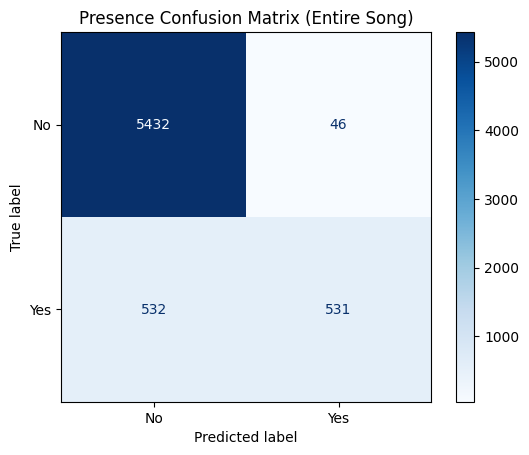

Presence Accuracy: 0.9116
Presence Precision: 0.9203
Presence Recall: 0.4995
Presence F1 Score: 0.6476
Type Confusion Matrix (Entire Song):
 [[448   0   0   0   0]
 [ 11   0   0   0   0]
 [  3   0   0   0   0]
 [ 25   0   0   0   0]
 [ 60   0   0   0   0]]


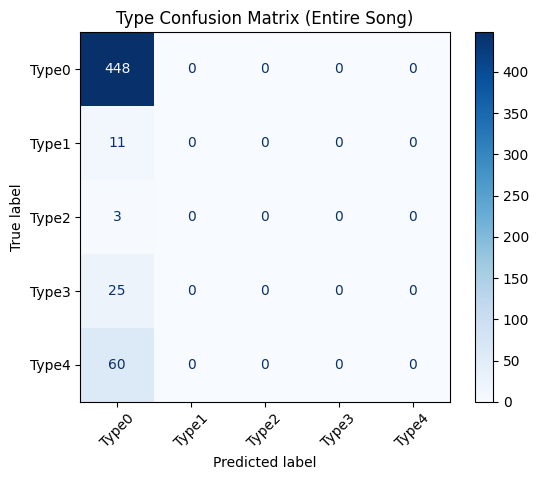

Type Accuracy: 0.7764
Type Precision: 0.6028
Type Recall: 0.7764
Type F1 Score: 0.6787


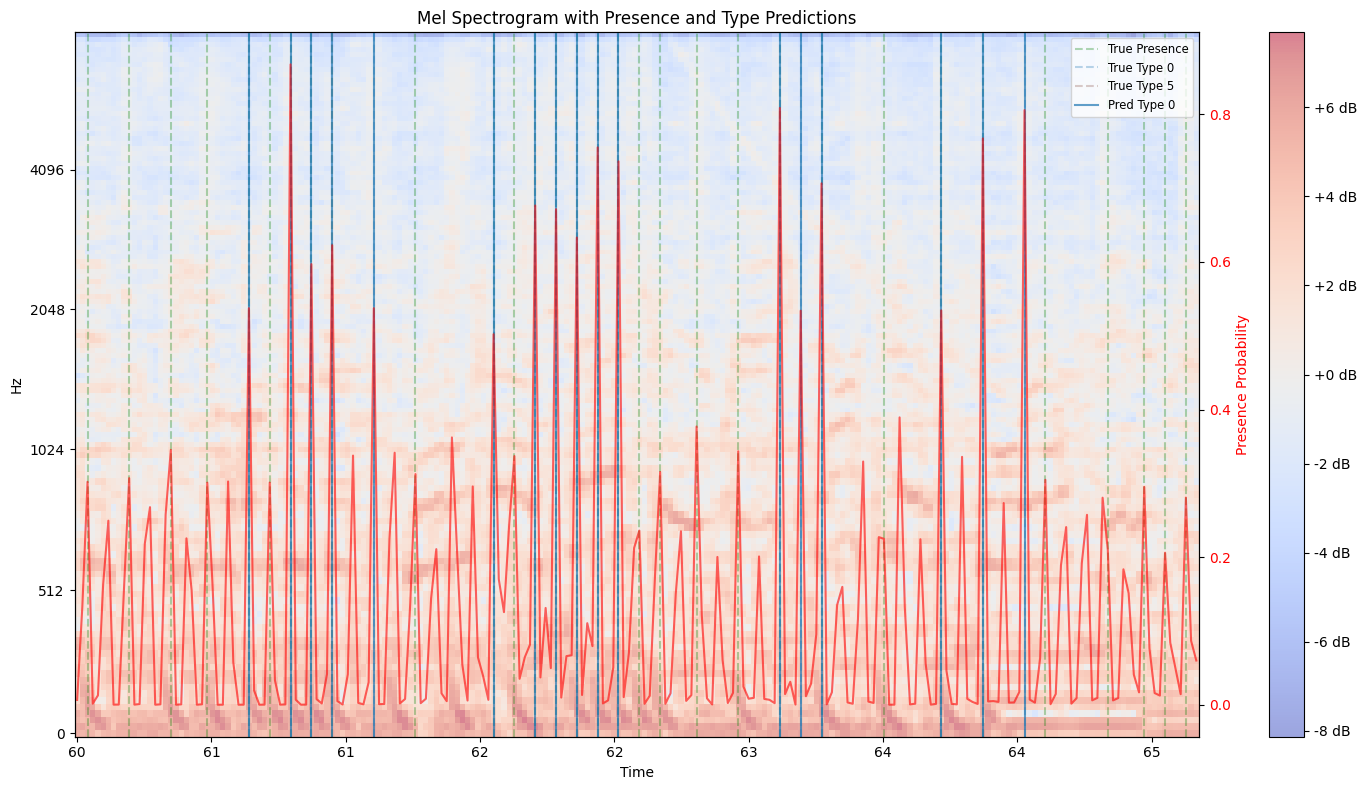


=== Visualization Segment Metrics ===

Presence Confusion Matrix (Segment):
 [[182   3]
 [ 17  14]]


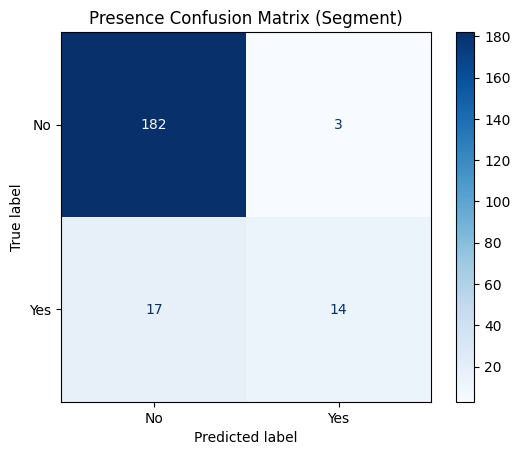

Segment Presence Accuracy: 0.9074
Segment Presence Precision: 0.8235
Segment Presence Recall: 0.4516
Segment Presence F1 Score: 0.5833
Type Confusion Matrix (Segment):
 [[16  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


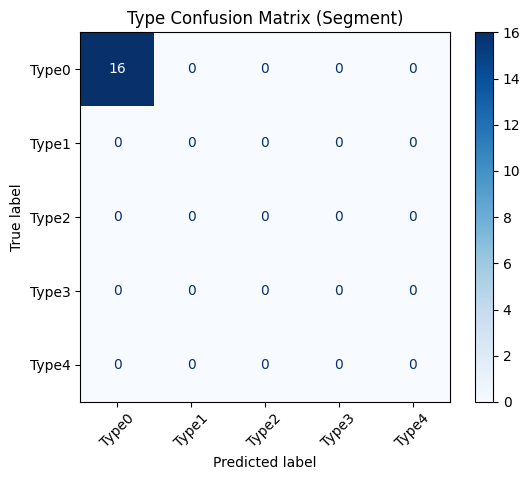

Segment Type Accuracy: 0.9412
Segment Type Precision: 0.8858
Segment Type Recall: 0.9412
Segment Type F1 Score: 0.9127

=== Done ===


In [ ]:
# %% import os
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import json
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple
import tqdm
from collections import defaultdict
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# STFT Constants
SAMPLE_RATE = 22050  
HOP_LENGTH = 512     
NMELS = 128        
WINDOW_SIZE = 40  # 40 frames before and after

# Visualization Time Range (seconds)
START_TIME = 60  # Start time
END_TIME = 65    # End time

# Model Paths (Modify according to your model paths)
MODEL_DIR = Path('./model')
PRESENCE_MODEL_PATH = MODEL_DIR / 'best_cnn_onset_model.pth'
TYPE_MODEL_PATH = MODEL_DIR / 'best_cnn_type_model.pth'

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

###########################
# Model Definitions (Keep consistent with before)
###########################
class CNNOnsetDetector(nn.Module):
    """
    CNN-based Onset Detection Model.
    """
    def __init__(self, input_channels: int, num_classes: int = 1, dropout: float = 0.5):
        super(CNNOnsetDetector, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.pool_layers = 3
        self.feature_length = 81
        for _ in range(self.pool_layers):
            self.feature_length = self.feature_length // 2
        self.feature_length = max(self.feature_length, 1)
        
        self.fc1 = nn.Linear(256 * self.feature_length, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, n_mels, 81]
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # [B,64,40]
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)  # [B,128,20]
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)  # [B,256,10]
        
        x = x.view(x.size(0), -1)  # [B,2560]
        x = self.dropout(x)
        x = self.fc1(x)  # [B,512]
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # [B,num_classes]
        
        return x

class CNNTypePredictor(nn.Module):
    """
    CNN-based Type Prediction Model.
    """
    def __init__(self, input_channels: int, num_types: int = 5, dropout: float = 0.5):
        super(CNNTypePredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.conv3 = nn.Conv1d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.pool_layers = 3
        self.feature_length = 81
        for _ in range(self.pool_layers):
            self.feature_length = self.feature_length // 2
        self.feature_length = max(self.feature_length, 1)
        
        self.fc1 = nn.Linear(256 * self.feature_length, 512)
        self.fc_type = nn.Linear(512, num_types)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, n_mels, 81]
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # [B,64,40]
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)  # [B,128,20]
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)  # [B,256,10]
        
        x = x.view(x.size(0), -1)  # [B,2560]
        x = self.dropout(x)
        x = self.fc1(x)  # [B,512]
        x = self.relu(x)
        x = self.dropout(x)
        type_out = self.fc_type(x)  # [B,num_types]
        
        return type_out

##############################
# Data Processing Functions
##############################
def extract_level_json(directory: Path, min_difficulty: int = 15) -> Dict[str, Any]:
    result = {}
    
    for folder_path in directory.iterdir():
        if not folder_path.is_dir():
            continue
        json_file_path = folder_path / 'level.json'
        if json_file_path.is_file():
            with json_file_path.open('r', encoding='utf-8') as json_file:
                try:
                    level_data = json.load(json_file)
                except json.JSONDecodeError:
                    continue

            chart_difficulty = level_data['charts'][0].get('difficulty', 0)
            if chart_difficulty < min_difficulty:
                continue

            audio_file_name = level_data['music']['path']
            audio_file_extensions = ['.mp3', '.ogg', '.wav']
            audio_file_path = None

            for ext in audio_file_extensions:
                aud_path = folder_path / audio_file_name
                if aud_path.suffix.lower() == ext and aud_path.is_file():
                    audio_file_path = aud_path
                    break
            if audio_file_path is None:
                continue

            charts_path = folder_path / level_data['charts'][0]['path']
            if not charts_path.is_file():
                continue

            result[level_data['id']] = {
                'level': level_data,
                'mp3_path': str(audio_file_path),
                'charts_path': str(charts_path),
                'charter': level_data.get('charter', ''),
                'type': level_data['charts'][0].get('type', ''),
                'difficulty': chart_difficulty
            }
    return result

def extract_charts(path: str) -> Dict[str, Any]:
    file_path = Path(path)
    if file_path.exists() and file_path.is_file():
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                return data
            except json.JSONDecodeError:
                pass
    return {}

def map_note_to_time(data: Dict[str, Any]) -> List[Dict[str, Any]]:
    time_base = data.get('time_base', 1000) 
    offset_universal = 0.033 
    offset = data.get('music_offset', 0) - offset_universal
    tempo_list = sorted(data.get('tempo_list', []), key=lambda x: x['tick'])
    note_list = data.get('note_list', [])
    
    note_time_map = []
    accumulated_time = 0 
    last_tick = 0  
    if not tempo_list:
        return note_time_map
    current_tempo = tempo_list[0]['value']  
    tempo_index = 0  
  
    for note in note_list:
        note_tick = note['tick']
        while tempo_index < len(tempo_list) - 1 and tempo_list[tempo_index + 1]['tick'] <= note_tick:
            next_tempo_tick = tempo_list[tempo_index + 1]['tick']
            ticks_in_interval = next_tempo_tick - last_tick
            tick_duration = (current_tempo / time_base) 
            accumulated_time += ticks_in_interval * tick_duration
            last_tick = next_tempo_tick
            tempo_index += 1
            current_tempo = tempo_list[tempo_index]['value']

        ticks_in_interval = note_tick - last_tick
        tick_duration = (current_tempo / time_base) 
        note_time = accumulated_time + ticks_in_interval * tick_duration
        note_time_map.append({
            'note_id': note.get('id', 0),
            'note_tick': note_tick,
            'note_time_microseconds': note_time - offset * 1_000_000,
            'note_type': note.get('type', 0),
            'note_x': note.get('x', 0.0)
        })
    
    return note_time_map

def generate_mel_spectrogram(
    audio_path: Path,
    log_enable: bool = True,
    bpm_info: List[Dict[str, float]] = None,
    note_info: List[Dict[str, Any]] = None,
    max_frames: int = 50000
) -> dict:
    data, sr = librosa.load(str(audio_path), sr=SAMPLE_RATE)
    assert sr == SAMPLE_RATE, f"Expected sample rate {SAMPLE_RATE}, but got {sr}"

    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sr, 
        hop_length=HOP_LENGTH, 
        fmin=30.0, 
        n_mels=NMELS, 
        htk=True
    )
    if log_enable:
        mel = np.log(np.clip(mel, 1e-5, None))
    mel = mel.T  # (time, n_mels)

    if mel.shape[0] > max_frames:
        mel = mel[:max_frames]
    
    data_dic = {"mel": mel}

    if bpm_info and note_info:
        mel_length = mel.shape[0]
        labels_presence = np.zeros((mel_length, 1))  # (mel_length,1)
        labels_type = np.zeros((mel_length,), dtype=int)
        for note in note_info:
            time_sec = note['note_time_microseconds'] / 1_000_000
            frame_idx = int(time_sec * SAMPLE_RATE / HOP_LENGTH)
            if 0 <= frame_idx < mel_length:
                labels_presence[frame_idx, 0] = 1
                labels_type[frame_idx] = note['note_type']
        data_dic["labels_presence"] = labels_presence
        data_dic["labels_type"] = labels_type
    else:
        data_dic["labels_presence"] = None
        data_dic["labels_type"] = None

    return data_dic

def extract_windows(mel: np.ndarray, window_size: int = 40) -> torch.Tensor:
    """
    Extract a window of (81) frames consisting of window_size frames before and after for each frame.
    """
    num_frames = mel.shape[0]
    padded = np.pad(mel, ((window_size, window_size), (0,0)), mode='constant')
    windows = []
    for i in range(window_size, window_size+num_frames):
        win = padded[i-window_size:i+window_size+1]
        windows.append(win)
    windows = np.array(windows)  # [num_frames,81,n_mels]
    return torch.from_numpy(windows).float()

def get_frame_indices(start_time: float, end_time: float, hop_length: int, sample_rate: int, total_frames: int) -> Tuple[int, int]:
    start_frame = int(start_time * sample_rate / hop_length)
    end_frame = int(end_time * sample_rate / hop_length)
    start_frame = max(start_frame, 0)
    end_frame = min(end_frame, total_frames)
    return start_frame, end_frame

def visualize_predictions(
    mel: np.ndarray,
    presence_probs: np.ndarray,
    presence_preds: np.ndarray,
    presence_indices: np.ndarray,
    type_preds: np.ndarray,
    true_types: np.ndarray = None,
    start_time: float = 0,
    end_time: float = 5,
    sample_rate: int = SAMPLE_RATE,
    hop_length: int = HOP_LENGTH,
    num_types: int = 5,
    true_presence_indices: np.ndarray = None
):
    times = np.linspace(start_time, end_time, num=mel.shape[0])
    fig, ax1 = plt.subplots(figsize=(15, 8))
    img = librosa.display.specshow(
        mel.T,
        sr=sample_rate,
        hop_length=hop_length,
        x_coords=times,
        ax=ax1,
        x_axis='time',
        y_axis='mel',
        fmax=8000,
        alpha=0.5
    )
    ax1.set_title('Mel Spectrogram with Presence and Type Predictions')
    fig.colorbar(img, ax=ax1, format='%+2.0f dB')

    ax2 = ax1.twinx()
    ax2.plot(times, presence_probs, label='Presence Probability', color='red', alpha=0.6)
    ax2.set_ylabel('Presence Probability', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # True presence lines
    if true_presence_indices is not None and len(true_presence_indices) > 0:
        for i, idx in enumerate(true_presence_indices):
            t = times[idx]
            ax1.axvline(x=t, color='green', linestyle='--', alpha=0.3, label='True Presence' if i == 0 else "")

    # True types
    if true_types is not None and len(true_types) > 0:
        unique_types = np.unique(true_types)
        for ttype in unique_types:
            idxs = np.where(true_types == ttype)[0]
            for j, idx in enumerate(idxs):
                frame_idx = presence_indices[idx]
                t = times[frame_idx]
                color = plt.cm.tab10(ttype % 10)
                ax1.axvline(x=t, color=color, linestyle='--', alpha=0.3, label=f'True Type {ttype}' if j == 0 else "")

    # Predicted types
    if len(type_preds) > 0:
        unique_pred_types = np.unique(type_preds)
        for ttype in unique_pred_types:
            idxs = np.where(type_preds == ttype)[0]
            for j, idx in enumerate(idxs):
                frame_idx = presence_indices[idx]
                t = times[frame_idx]
                color = plt.cm.tab10(ttype % 10)
                ax1.axvline(x=t, color=color, linestyle='-', alpha=0.7, label=f'Pred Type {ttype}' if j == 0 else "")

    handles, labels_legend = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels_legend, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()

###############################
# Main Process
###############################
    
# Dataset directory, modify according to your actual dataset path
current_directory = Path().cwd()
dataset_dir = current_directory.parent / "dataset" / "Z"
data = extract_level_json(dataset_dir, min_difficulty=15)
print(f"Filtered Data Count (Difficulty>=15): {len(data)}")

if len(data) == 0:
    raise ValueError("No data meets the criteria. Please check the dataset.")

# Randomly select a song
sample_song_id, sample_song = next(iter(data.items()))
print(f"Selected Song ID: {sample_song_id}")
print(f"Audio Path: {sample_song['mp3_path']}")

charts_data = extract_charts(sample_song['charts_path'])
bpm_info = charts_data.get('tempo_list', [])
note_time_map = map_note_to_time(charts_data) 
score_positions = [] 
for note in note_time_map:
    score_positions.append({
        'note_time_microseconds': note['note_time_microseconds'],
        'note_type': note['note_type'],
        'note_x': note['note_x']
    })

mel_dict = generate_mel_spectrogram(
    audio_path=Path(sample_song['mp3_path']),
    log_enable=True,
    bpm_info=bpm_info,
    note_info=score_positions
)

mel = mel_dict["mel"]
labels_presence = mel_dict["labels_presence"]  # (num_frames,1)
labels_type = mel_dict["labels_type"]  # (num_frames,)

total_frames = mel.shape[0]
total_time = total_frames * HOP_LENGTH / SAMPLE_RATE
print(f"Total Time: {total_time:.2f} seconds")

# Load Models
presence_model = CNNOnsetDetector(input_channels=NMELS, num_classes=1, dropout=0.5)
presence_model.load_state_dict(torch.load(PRESENCE_MODEL_PATH, map_location=device))
presence_model.to(device)
presence_model.eval()
print("Loaded Presence Model")

num_types = 5
type_model = CNNTypePredictor(input_channels=NMELS, num_types=num_types, dropout=0.5)
type_model.load_state_dict(torch.load(TYPE_MODEL_PATH, map_location=device))
type_model.to(device)
type_model.eval()
print("Loaded Type Model")

# Predict Entire Song
mel_windows_full = extract_windows(mel, window_size=WINDOW_SIZE).to(device)
batch_size = 512
presence_probs_full = []
presence_preds_full = []

with torch.no_grad():
    for i in range(0, mel_windows_full.size(0), batch_size):
        batch = mel_windows_full[i:i+batch_size]
        outputs = presence_model(batch)
        probs = torch.sigmoid(outputs).squeeze(1).cpu().numpy()
        preds_batch = (probs >= 0.5).astype(int)
        presence_probs_full.extend(probs)
        presence_preds_full.extend(preds_batch)
    
presence_probs_full = np.array(presence_probs_full)
presence_preds_full = np.array(presence_preds_full)
presence_indices_full = np.where(presence_preds_full == 1)[0]

if labels_presence is not None:
    true_presence_indices_full = np.where(labels_presence.squeeze(1)==1)[0]
else:
    true_presence_indices_full = None

# Type Prediction (Entire Song)
type_preds_full = []
if len(presence_indices_full) > 0:
    mel_presence_full = mel[presence_indices_full]
    mel_presence_full_windows = extract_windows(mel_presence_full, WINDOW_SIZE).to(device)
    with torch.no_grad():
        for i in range(0, mel_presence_full_windows.size(0), batch_size):
            batch = mel_presence_full_windows[i:i+batch_size]
            outputs = type_model(batch)
            preds_batch = torch.argmax(F.softmax(outputs,dim=1), dim=1).cpu().numpy()
            type_preds_full.extend(preds_batch)
    type_preds_full = np.array(type_preds_full)
    if labels_type is not None:
        true_types_full = labels_type[presence_indices_full]
    else:
        true_types_full = None
else:
    type_preds_full = np.array([])
    true_types_full = None

# Calculate Confusion Matrix and Metrics for Entire Song
print("\n=== Entire Song Metrics ===\n")
if labels_presence is not None:
    presence_cm_full = confusion_matrix(labels_presence.squeeze(1), presence_preds_full)
    print("Presence Confusion Matrix (Entire Song):\n", presence_cm_full)
    ConfusionMatrixDisplay(presence_cm_full, display_labels=['No','Yes']).plot(cmap='Blues')
    plt.title("Presence Confusion Matrix (Entire Song)")
    plt.show()

    presence_acc = accuracy_score(labels_presence.squeeze(1), presence_preds_full)
    presence_prec = precision_score(labels_presence.squeeze(1), presence_preds_full, zero_division=0)
    presence_recall = recall_score(labels_presence.squeeze(1), presence_preds_full, zero_division=0)
    presence_f1 = f1_score(labels_presence.squeeze(1), presence_preds_full, zero_division=0)
    print(f"Presence Accuracy: {presence_acc:.4f}")
    print(f"Presence Precision: {presence_prec:.4f}")
    print(f"Presence Recall: {presence_recall:.4f}")
    print(f"Presence F1 Score: {presence_f1:.4f}")

if true_types_full is not None and len(type_preds_full)>0:
    type_cm_full = confusion_matrix(true_types_full, type_preds_full, labels=range(num_types))
    print("Type Confusion Matrix (Entire Song):\n", type_cm_full)
    ConfusionMatrixDisplay(type_cm_full, display_labels=[f'Type{i}' for i in range(num_types)]).plot(cmap='Blues', xticks_rotation=45)
    plt.title("Type Confusion Matrix (Entire Song)")
    plt.show()

    type_acc = accuracy_score(true_types_full, type_preds_full)
    type_prec = precision_score(true_types_full, type_preds_full, average='weighted', zero_division=0)
    type_recall = recall_score(true_types_full, type_preds_full, average='weighted', zero_division=0)
    type_f1 = f1_score(true_types_full, type_preds_full, average='weighted', zero_division=0)
    print(f"Type Accuracy: {type_acc:.4f}")
    print(f"Type Precision: {type_prec:.4f}")
    print(f"Type Recall: {type_recall:.4f}")
    print(f"Type F1 Score: {type_f1:.4f}")

# Predict and Visualize in a Specific Time Segment
start_frame, end_frame = get_frame_indices(START_TIME, END_TIME, HOP_LENGTH, SAMPLE_RATE, total_frames)
mel_visual = mel[start_frame:end_frame]
labels_presence_visual = labels_presence[start_frame:end_frame] if labels_presence is not None else None
labels_type_visual = labels_type[start_frame:end_frame] if labels_type is not None else None

mel_windows_visual = extract_windows(mel_visual, WINDOW_SIZE).to(device)
presence_probs_visual = []
presence_preds_visual = []
with torch.no_grad():
    for i in range(0, mel_windows_visual.size(0), batch_size):
        batch = mel_windows_visual[i:i+batch_size]
        outputs = presence_model(batch)
        probs = torch.sigmoid(outputs).squeeze(1).cpu().numpy()
        preds_batch = (probs >= 0.5).astype(int)
        presence_probs_visual.extend(probs)
        presence_preds_visual.extend(preds_batch)
presence_probs_visual = np.array(presence_probs_visual)
presence_preds_visual = np.array(presence_preds_visual)
presence_indices_visual = np.where(presence_preds_visual == 1)[0]

if labels_presence_visual is not None:
    true_presence_indices_visual = np.where(labels_presence_visual.squeeze(1) == 1)[0]
else:
    true_presence_indices_visual = None

type_preds_visual = []
if len(presence_indices_visual)>0:
    mel_presence_visual = mel_visual[presence_indices_visual]
    mel_presence_visual_windows = extract_windows(mel_presence_visual, WINDOW_SIZE).to(device)
    with torch.no_grad():
        for i in range(0, mel_presence_visual_windows.size(0), batch_size):
            batch = mel_presence_visual_windows[i:i+batch_size]
            outputs = type_model(batch)
            preds_batch = torch.argmax(F.softmax(outputs,dim=1),dim=1).cpu().numpy()
            type_preds_visual.extend(preds_batch)
    type_preds_visual = np.array(type_preds_visual)
    if labels_type_visual is not None:
        true_types_visual = labels_type_visual[presence_indices_visual]
    else:
        true_types_visual = None
else:
    type_preds_visual = np.array([])
    true_types_visual = None

visualize_predictions(
    mel=mel_visual,
    presence_probs=presence_probs_visual,
    presence_preds=presence_preds_visual,
    presence_indices=presence_indices_visual,
    type_preds=type_preds_visual,
    true_types=true_types_visual,
    start_time=START_TIME,
    end_time=END_TIME,
    sample_rate=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    num_types=num_types,
    true_presence_indices=true_presence_indices_visual
)

print("\n=== Visualization Segment Metrics ===\n")
if labels_presence_visual is not None:
    presence_cm_visual = confusion_matrix(labels_presence_visual.squeeze(1), presence_preds_visual)
    print("Presence Confusion Matrix (Segment):\n", presence_cm_visual)
    ConfusionMatrixDisplay(presence_cm_visual, display_labels=['No','Yes']).plot(cmap='Blues')
    plt.title("Presence Confusion Matrix (Segment)")
    plt.show()

    presence_acc_v = accuracy_score(labels_presence_visual.squeeze(1), presence_preds_visual)
    presence_prec_v = precision_score(labels_presence_visual.squeeze(1), presence_preds_visual, zero_division=0)
    presence_recall_v = recall_score(labels_presence_visual.squeeze(1), presence_preds_visual, zero_division=0)
    presence_f1_v = f1_score(labels_presence_visual.squeeze(1), presence_preds_visual, zero_division=0)
    print(f"Segment Presence Accuracy: {presence_acc_v:.4f}")
    print(f"Segment Presence Precision: {presence_prec_v:.4f}")
    print(f"Segment Presence Recall: {presence_recall_v:.4f}")
    print(f"Segment Presence F1 Score: {presence_f1_v:.4f}")

if true_types_visual is not None and len(type_preds_visual)>0:
    type_cm_visual = confusion_matrix(true_types_visual, type_preds_visual, labels=range(num_types))
    print("Type Confusion Matrix (Segment):\n", type_cm_visual)
    ConfusionMatrixDisplay(type_cm_visual, display_labels=[f'Type{i}' for i in range(num_types)]).plot(cmap='Blues', xticks_rotation=45)
    plt.title("Type Confusion Matrix (Segment)")
    plt.show()

    type_acc_v = accuracy_score(true_types_visual, type_preds_visual)
    type_prec_v = precision_score(true_types_visual, type_preds_visual, average='weighted', zero_division=0)
    type_recall_v = recall_score(true_types_visual, type_preds_visual, average='weighted', zero_division=0)
    type_f1_v = f1_score(true_types_visual, type_preds_visual, average='weighted', zero_division=0)
    print(f"Segment Type Accuracy: {type_acc_v:.4f}")
    print(f"Segment Type Precision: {type_prec_v:.4f}")
    print(f"Segment Type Recall: {type_recall_v:.4f}")
    print(f"Segment Type F1 Score: {type_f1_v:.4f}")

print("\n=== Done ===")
